<a href="https://colab.research.google.com/github/Anubrat/Adminator-admin-dashboard/blob/master/arrhythmia_on_ecg_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Analaysis and Machine Learning Model in Electrocardiography based on Internet of Medical Things (IOMT)

**What is an ecg? **

An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats.

These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.

An ECG may be requested by a heart specialist (cardiologist) or any doctor who thinks you might have a problem with your heart, including your GP.
That's the result of this test we will analyze. 

https://physionet.org/content/mitdb/1.0.0/
Arrhythmia Dataset
    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz
    Data Source: Physionet's MIT-BIH Arrhythmia Dataset
    
    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
-N : Non-ecotic beats (normal beat)
-S : Supraventricular ectopic beats
-V : Ventricular ectopic beats
-F : Fusion Beats
-Q : Unknown Beats

**Load Data**

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mitbih_test.csv',header=None)

**Balance of dataset**

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


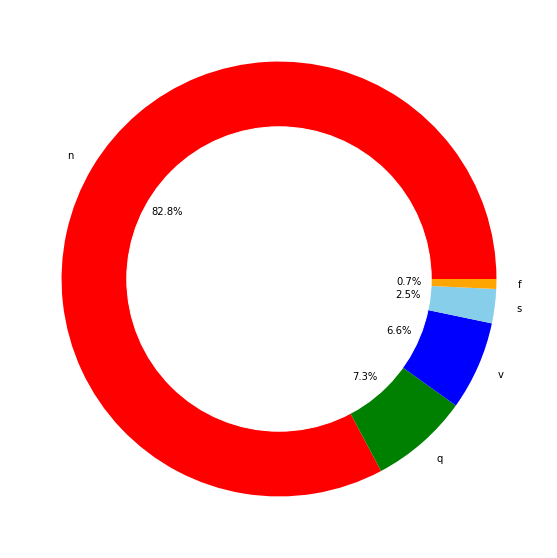

In [8]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

We can underligned a huge difference in the balanced of the classes. After some try i have decided to  choose the resample technique more than the class weights for the algorithms. 

In [9]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [10]:
equilibre=train_df[187].value_counts()
print(equilibre)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


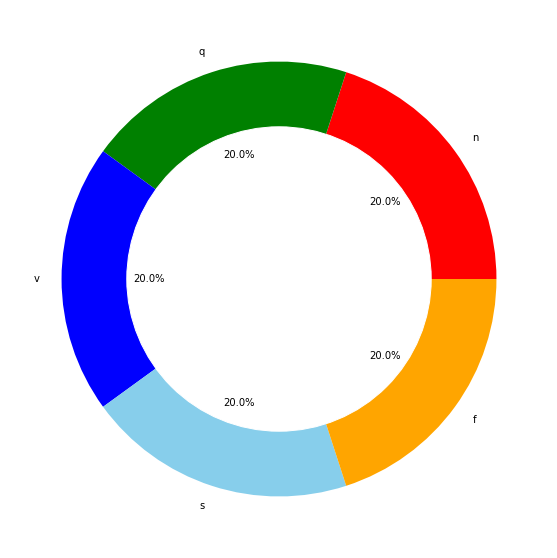

In [11]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Resample works perfectly we can go on. 

**Classes**

In this part i want to study the differente classes. 

In [12]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

I take one sample per class and i store it in a datafrmae in order to have an example. 

In [13]:
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
21680,0.973770,0.521311,0.000000,0.016393,0.049180,0.072131,0.065574,0.078689,0.065574,0.078689,0.068852,0.078689,0.059016,0.081967,0.065574,0.075410,0.062295,0.085246,0.075410,0.091803,0.075410,0.091803,0.078689,0.091803,0.072131,0.085246,0.075410,0.088525,0.072131,0.081967,0.065574,0.072131,0.059016,0.068852,0.065574,0.095082,0.108197,0.150820,0.157377,0.180328,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0
72498,0.813433,0.720149,0.167910,0.000000,0.082090,0.145522,0.119403,0.175373,0.223881,0.197761,0.167910,0.194030,0.261194,0.309702,0.294776,0.291045,0.294776,0.309702,0.291045,0.291045,0.317164,0.313433,0.313433,0.313433,0.335821,0.347015,0.343284,0.354478,0.384328,0.406716,0.425373,0.447761,0.477612,0.488806,0.481343,0.500000,0.526119,0.514925,0.470149,0.444030,...,0.257463,0.257463,0.25,0.246269,0.25,0.25,0.223881,0.242537,0.242537,0.264925,0.223881,0.220149,0.261194,0.238806,0.223881,0.257463,0.257463,0.231343,0.235075,0.223881,0.235075,0.238806,0.227612,0.223881,0.235075,0.257463,0.276119,0.25,0.25,0.261194,0.272388,0.261194,0.261194,0.261194,0.246269,0.25,0.283582,0.272388,0.268657,1
74903,0.998824,1.000000,0.937647,0.895294,0.891765,0.811765,0.658824,0.422353,0.247059,0.247059,0.236471,0.197647,0.183529,0.180000,0.165882,0.154118,0.150588,0.141176,0.131765,0.116471,0.105882,0.098824,0.085882,0.060000,0.045882,0.040000,0.022353,0.011765,0.005882,0.000000,0.002353,0.004706,0.009412,0.008235,0.017647,0.018824,0.022353,0.045882,0.080000,0.111765,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,2
81067,1.000000,0.947905,0.763307,0.457531,0.160815,0.135900,0.157418,0.121178,0.103058,0.087203,0.072480,0.066818,0.048698,0.030578,0.021518,0.014723,0.005663,0.000000,0.001133,0.012458,0.019253,0.029445,0.060023,0.082673,0.099660,0.129105,0.169875,0.210646,0.242356,0.262741,0.289921,0.304643,0.306908,0.319366,0.322763,0.321631,0.318233,0.309173,0.305776,0.305776,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,3
86249,0.718850,0.587859,0.463259,0.308307,0.174121,0.073482,0.022364,0.000000,0.043131,0.107029,0.239617,0.337061,0.388179,0.445687,0.514377,0.570288,0.626198,0.654952,0.678914,0.686901,0.691693,0.701278,0.715655,0.715655,0.731629,0.734824,0.753994,0.763578,0.797125,0.800319,0.833866,0.846645,0.873802,0.888179,0.924920,0.934505,0.952077,0.953674,0.964856,0.958466,...,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,4


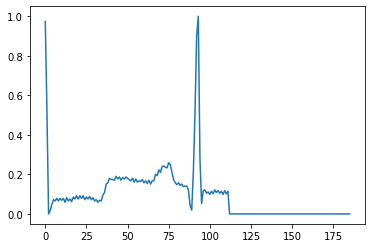

In [14]:
 plt.plot(c.iloc[0,:186])

Here is a normal beat. I don't have something particular to say on that class.  

Error Unknown !!

In [15]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


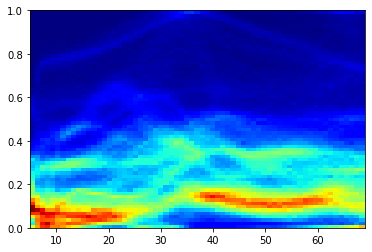

In [16]:
plot_hist(0,70,5,65)

Here is a representation for all the class. We take all the signal and map them. Like that we have an estimation what the signal can look like.

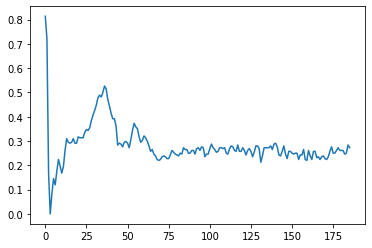

In [17]:
 plt.plot(c.iloc[1,:186])

900000
900000


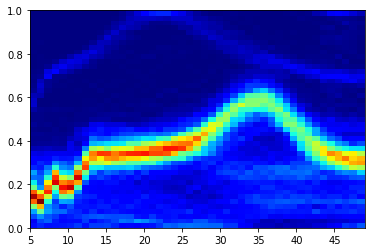

In [18]:
plot_hist(1,50,5,45)

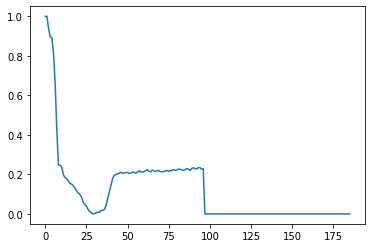

In [19]:
 plt.plot(c.iloc[2,:186])

900000
900000


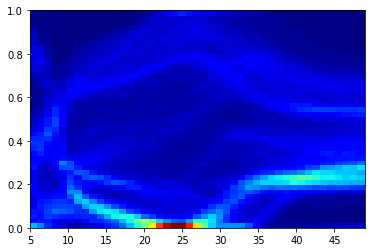

In [20]:
plot_hist(2,50,5,45)

Here is an exemple of the two classes :

![4-Figure2-1.png](attachment:4-Figure2-1.png)

in the second and third line you have the 2 et 3 class.

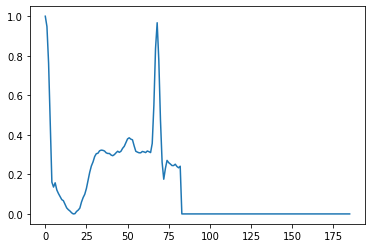

In [21]:
plt.plot(c.iloc[3,:186])

900000
900000


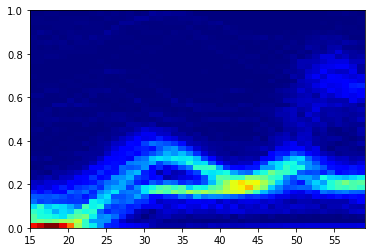

In [22]:
plot_hist(3,60,15,45)

Fusion beat :
![3-s2.0-B9780124159365000098-f09-10-9780124159365.jpg](attachment:3-s2.0-B9780124159365000098-f09-10-9780124159365.jpg)

Don't really see the difference with the previous one but i'm not an expert of ECG!

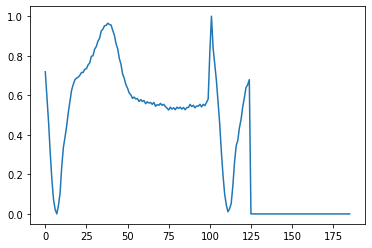

In [23]:
plt.plot(c.iloc[4,:186])

I will not comment a lot this one because it correspond to other class. 

700000
700000


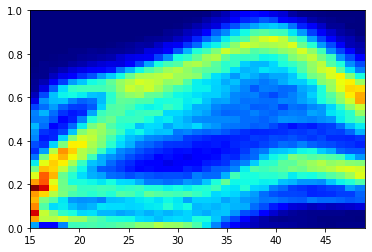

In [24]:
plot_hist(4,50,15,35)

**Pretreat**

In this part i will speak o n what i do to transform data. 

In [25]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


I use a fonction ( will depend of the version) where i add a noise to the data to generilize my train.

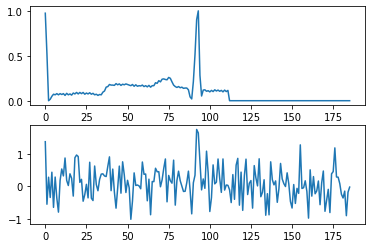

In [26]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()



In [27]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [28]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

# More Test ON

In [29]:
XX_train, XX_val, yy_train, yy_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Network

In [30]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
     
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=40),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=150,callbacks=callbacks, batch_size=32,validation_data=(XX_val,yy_val))
    model.load_weights('best_model.h5')
    return(model,history)
   

In [31]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [32]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/150
3125/3125 [==============================] - 78s 24ms/step - loss: 1.0139 - accuracy: 0.6030 - val_loss: 0.8165 - val_accuracy: 0.6902
Epoch 2/150
3125/3125 [==============================] - 76s 24ms/step - loss: 0.7967 - accuracy: 0.6965 - val_loss: 0.7926 - val_accuracy: 0.7017
Epoch 3/150
3125/3125 [==============================] - 77s 25ms/step - loss: 0.7586 - accuracy: 0.7140 - val_loss: 0.7290 - val_accuracy: 0.7248
Epoch 4/150
3125/3125 [==============================] - 77s 25ms/step - loss: 0.7387 - accuracy: 0.7204 - val_loss: 0.7067 - val_accuracy: 0.7338
Epoch 5/150
3125/3125 [==============================] - 77s 24ms/step - loss: 0.7094 - accuracy: 0.7308 - val_loss: 0.6781 - val_accuracy: 0.7441
Epoch 6/150
3125/3125 [==============================] - 77s 25ms/step - loss: 0.6825 - accuracy: 0.7445 - val_loss: 0.6432 - val_accuracy: 0.7598
Epoch 7/150
3125/3125 [==============================] - 76s 24ms/step - loss: 0.6519 - accuracy: 0.7538 - val_loss: 0

Accuracy: 13.21%


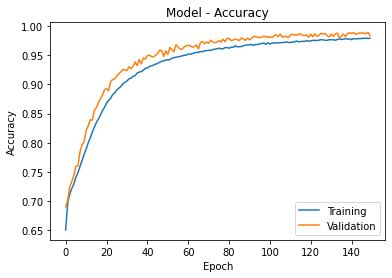

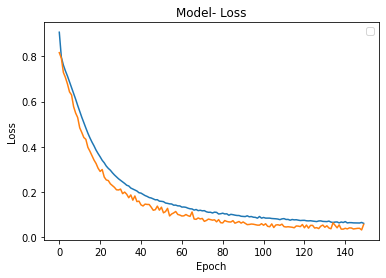

In [33]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)


i take the next function from : https://www.kaggle.com/coni57/model-from-arxiv-1805-00794

Normalized confusion matrix


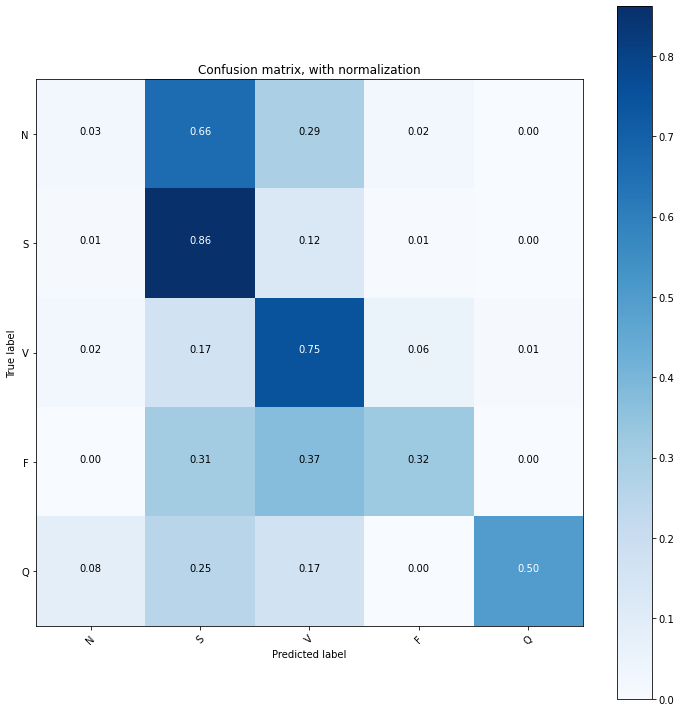

In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()



We underlign that two class(supraventricular and fusion) is weeker than the other. maybe due to less exemple in the starter dataset. I will try to improve in the next version.